# Setting folder

In [79]:
%pwd

'/workspace'

# Import

In [80]:
import os
import time

from tqdm.notebook import tqdm

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# import albumentations as A
# import albumentations.pytorch as Ap

from torchvision import transforms
import torchvision.models as models

# ResNet50

In [81]:
class ResBlock(torch.nn.Module):
    def __init__(self, in_f, f_1, out_f, stride=1):
        super(ResBlock, self).__init__()
        self.stride = stride
        self.fit_dim = False

        self.block = nn.Sequential(
            nn.Conv2d(in_f, f_1, kernel_size=1, padding=0, stride=stride),
            nn.BatchNorm2d(f_1),
            nn.ReLU(),
            nn.Conv2d(f_1, f_1, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(f_1),
            nn.ReLU(),
            nn.Conv2d(f_1, out_f, kernel_size=1, padding=0, stride=1),
            nn.BatchNorm2d(out_f),
            nn.ReLU()
        )

        if in_f != out_f:
            self.fit_conv = nn.Conv2d(in_f, out_f, kernel_size=1, padding=0, stride=stride)
            self.fit_bn = nn.BatchNorm2d(out_f)
            self.fit_dim = True
        

    def forward(self, x):
        res_x = self.block(x)

        if self.fit_dim:
            x = self.fit_conv(x)
            x = self.fit_bn(x)
            x = F.relu(x)
        
        x = torch.add(res_x, x)
        x = F.relu(x)
        return x

class ResNet50(torch.nn.Module):
    def __init__(self, out_class):
        super(ResNet50, self).__init__()
        self.out_class = out_class

        self.module = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=7, padding=3, stride=2),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d([3,3], padding=1, stride=2),
                ResBlock(64, 64, 256), # ResBlock2
                ResBlock(256, 64, 256),
                ResBlock(256, 64, 256),
                ResBlock(256, 128, 512, stride=2), # ResBlock3
                ResBlock(512, 128, 512),
                ResBlock(512, 128, 512),
                ResBlock(512, 128, 512),
                ResBlock(512, 256, 1024, stride=2), # ResBlock 4
                ResBlock(1024, 256, 1024),
                ResBlock(1024, 256, 1024),
                ResBlock(1024, 256, 1024),
                ResBlock(1024, 256, 1024),
                ResBlock(1024, 256, 1024),
                ResBlock(1024, 512, 2048, stride=2), # ResBlock 5
                ResBlock(2048, 512, 2048),
                ResBlock(2048, 512, 2048)
            )

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))

        self.linear = nn.Linear(2048, self.out_class)

    def forward(self, x):
        x = self.module(x)
        x = self.avg_pool(x)
        x = x.view(x.size()[0], -1)
        x = self.linear(x)
        x = torch.sigmoid(x)
        
        return x

In [82]:
IN_HEIGHT, IN_WIDTH = 28, 28

RESOURCE = "GPU"

RANDOM_SEED = 46

if RESOURCE == "CPU":
    device = torch.device("cpu")
    torch.manual_seed(RANDOM_SEED)
elif RESOURCE == "GPU":
    device = torch.device("cuda")
    torch.cuda.manual_seed(RANDOM_SEED)

# prepare data

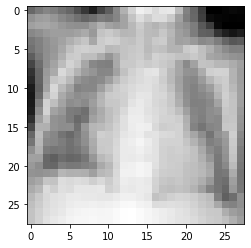

In [83]:
import numpy as np

dataset = np.load("pneumoniamnist.npz")
x_train, y_train, x_val, y_val, x_test, y_test = dataset['train_images'], dataset['train_labels'], dataset['val_images'], dataset['val_labels'], dataset['test_images'], dataset['test_labels']

def reshape(x):
    x = x.reshape([x.shape[0], x.shape[1], x.shape[2], 1])
    x = np.concatenate([x,x,x], axis=3)
    return x

plt.imshow(x_train[0], cmap='gray')

x_train = reshape(x_train)
x_val = reshape(x_val)

In [84]:
class MedMNISTDataset(Dataset):
    def __init__(self, xs, ys, transforms=None):
        self.xs = xs
        self.ys = ys
        self.transforms = transforms
        self.data_num = len(xs)

    def __len__(self):
        return self.data_num

    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]

        if self.transforms:
            x = self.transforms(x)
        
        return x, y

In [85]:
transforms_train = transforms.Compose([
    transforms.ToTensor(),
])

transforms_val = transforms.Compose([
    transforms.ToTensor(),
])

In [86]:
EPOCH = 100
BATCH_SIZE =  128
lr = 1e-3

dataset_train = MedMNISTDataset(xs=x_train, ys=y_train, transforms=transforms_train)
dataset_val = MedMNISTDataset(xs=x_val, ys=y_val, transforms=transforms_val)

train_n = len(dataset_train)
val_n = len(dataset_val)

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True)

# Model compile

In [87]:
model = ResNet50(out_class=1)
# model = models.resnet50(pretrained=True)
# model.fc = nn.Sequential(nn.Linear(2048,1), nn.Sigmoid())
model = model.to(device)

criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=lr)

print(model)

ResNet50(
  (module): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=[3, 3], stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): ResBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU()
      )
      (fit_conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (fit_bn): BatchNorm2d(2

# Train

  0%|          | 0/37 [00:00<?, ?it/s]

epoch:1/100 [train]loss0.002719 acc:0.9085, [val]loss:1.308952, acc:0.7740


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:2/100 [train]loss0.000797 acc:0.9628, [val]loss:0.121650, acc:0.9531


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:3/100 [train]loss0.000620 acc:0.9706, [val]loss:0.089789, acc:0.9568


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:4/100 [train]loss0.000387 acc:0.9823, [val]loss:0.090284, acc:0.9750


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:5/100 [train]loss0.000395 acc:0.9817, [val]loss:0.218469, acc:0.9297


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:6/100 [train]loss0.000414 acc:0.9792, [val]loss:0.133500, acc:0.9552


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:7/100 [train]loss0.000274 acc:0.9867, [val]loss:0.729406, acc:0.7932


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:8/100 [train]loss0.000267 acc:0.9873, [val]loss:0.244021, acc:0.9453


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:9/100 [train]loss0.000400 acc:0.9779, [val]loss:0.105516, acc:0.9656


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:10/100 [train]loss0.000291 acc:0.9862, [val]loss:0.113128, acc:0.9385


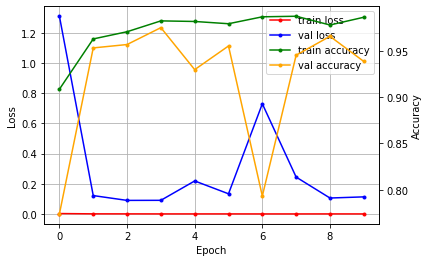

  0%|          | 0/37 [00:00<?, ?it/s]

epoch:11/100 [train]loss0.000212 acc:0.9881, [val]loss:0.438910, acc:0.9005


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:12/100 [train]loss0.000437 acc:0.9788, [val]loss:0.088777, acc:0.9688


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:13/100 [train]loss0.000151 acc:0.9933, [val]loss:0.106807, acc:0.9703


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:14/100 [train]loss0.000216 acc:0.9904, [val]loss:0.213697, acc:0.9609


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:15/100 [train]loss0.000277 acc:0.9860, [val]loss:0.111867, acc:0.9521


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:16/100 [train]loss0.000156 acc:0.9938, [val]loss:0.096867, acc:0.9615


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:17/100 [train]loss0.000117 acc:0.9953, [val]loss:0.121148, acc:0.9672


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:18/100 [train]loss0.000211 acc:0.9898, [val]loss:0.140296, acc:0.9531


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:19/100 [train]loss0.000321 acc:0.9924, [val]loss:3.554338, acc:0.9453


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:20/100 [train]loss0.000167 acc:0.9926, [val]loss:0.171833, acc:0.9641


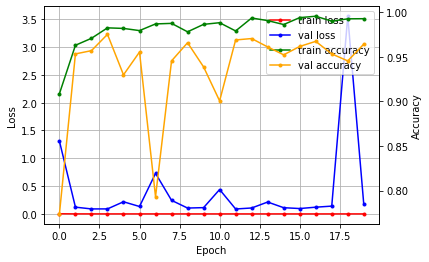

  0%|          | 0/37 [00:00<?, ?it/s]

epoch:21/100 [train]loss0.000136 acc:0.9935, [val]loss:0.134177, acc:0.9688


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:22/100 [train]loss0.000126 acc:0.9928, [val]loss:0.216933, acc:0.9443


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:23/100 [train]loss0.000151 acc:0.9932, [val]loss:0.221046, acc:0.9625


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:24/100 [train]loss0.000104 acc:0.9951, [val]loss:0.231027, acc:0.9458


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:25/100 [train]loss0.000081 acc:0.9959, [val]loss:0.371244, acc:0.9161


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:26/100 [train]loss0.000094 acc:0.9960, [val]loss:0.165662, acc:0.9734


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:27/100 [train]loss0.000033 acc:0.9987, [val]loss:0.153615, acc:0.9490


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:28/100 [train]loss0.000159 acc:0.9940, [val]loss:0.134350, acc:0.9339


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:29/100 [train]loss0.000159 acc:0.9928, [val]loss:0.130089, acc:0.9734


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:30/100 [train]loss0.000107 acc:0.9947, [val]loss:0.255701, acc:0.9516


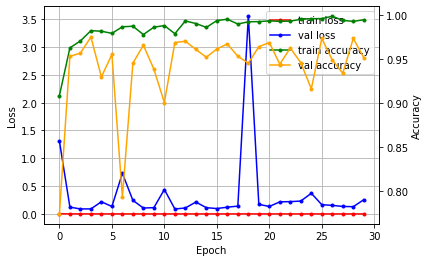

  0%|          | 0/37 [00:00<?, ?it/s]

epoch:31/100 [train]loss0.000336 acc:0.9928, [val]loss:0.162374, acc:0.9490


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:32/100 [train]loss0.000436 acc:0.9826, [val]loss:0.172566, acc:0.9198


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:33/100 [train]loss0.000438 acc:0.9788, [val]loss:0.084625, acc:0.9719


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:34/100 [train]loss0.000157 acc:0.9909, [val]loss:0.131486, acc:0.9536


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:35/100 [train]loss0.000170 acc:0.9926, [val]loss:0.150797, acc:0.9594


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:36/100 [train]loss0.000190 acc:0.9910, [val]loss:0.207271, acc:0.9391


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:37/100 [train]loss0.000110 acc:0.9945, [val]loss:0.123203, acc:0.9781


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:38/100 [train]loss0.000043 acc:0.9979, [val]loss:0.195965, acc:0.9474


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:39/100 [train]loss0.000137 acc:0.9930, [val]loss:0.279266, acc:0.9276


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:40/100 [train]loss0.000184 acc:0.9909, [val]loss:0.262584, acc:0.9318


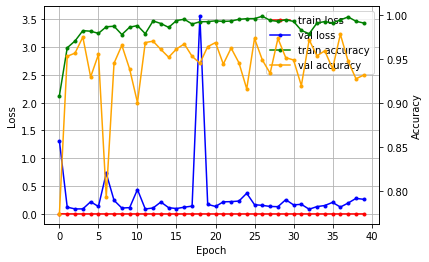

  0%|          | 0/37 [00:00<?, ?it/s]

epoch:41/100 [train]loss0.000104 acc:0.9956, [val]loss:0.141348, acc:0.9552


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:42/100 [train]loss0.000034 acc:0.9986, [val]loss:0.151203, acc:0.9464


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:43/100 [train]loss0.000081 acc:0.9955, [val]loss:0.115556, acc:0.9615


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:44/100 [train]loss0.000057 acc:0.9977, [val]loss:0.079873, acc:0.9797


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:45/100 [train]loss0.000041 acc:0.9978, [val]loss:0.193641, acc:0.9354


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:46/100 [train]loss0.000116 acc:0.9947, [val]loss:0.114759, acc:0.9385


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:47/100 [train]loss0.000059 acc:0.9977, [val]loss:0.156547, acc:0.9536


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:48/100 [train]loss0.000056 acc:0.9968, [val]loss:0.118372, acc:0.9797


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:49/100 [train]loss0.000039 acc:0.9983, [val]loss:0.273432, acc:0.9516


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:50/100 [train]loss0.000021 acc:0.9989, [val]loss:0.127844, acc:0.9766


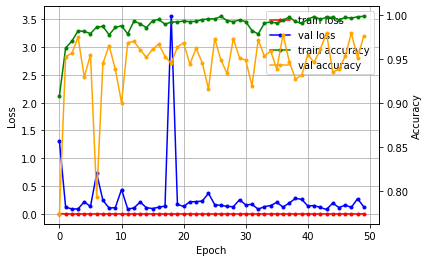

  0%|          | 0/37 [00:00<?, ?it/s]

epoch:51/100 [train]loss0.000022 acc:0.9987, [val]loss:0.178022, acc:0.9536


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:52/100 [train]loss0.000063 acc:0.9964, [val]loss:0.115905, acc:0.9766


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:53/100 [train]loss0.000031 acc:0.9985, [val]loss:0.102228, acc:0.9781


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:54/100 [train]loss0.000020 acc:0.9994, [val]loss:0.153779, acc:0.9536


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:55/100 [train]loss0.000012 acc:0.9994, [val]loss:0.154190, acc:0.9812


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:56/100 [train]loss0.000006 acc:0.9998, [val]loss:0.131083, acc:0.9828


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:57/100 [train]loss0.000078 acc:0.9976, [val]loss:0.171503, acc:0.9552


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:58/100 [train]loss0.000109 acc:0.9947, [val]loss:0.113803, acc:0.9734


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:59/100 [train]loss0.000054 acc:0.9975, [val]loss:0.271421, acc:0.9396


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:60/100 [train]loss0.000037 acc:0.9973, [val]loss:0.145223, acc:0.9750


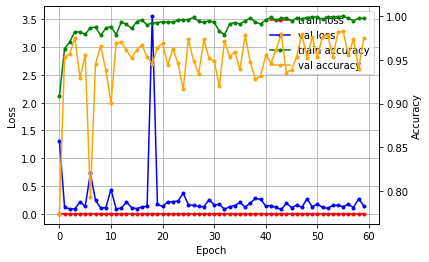

  0%|          | 0/37 [00:00<?, ?it/s]

epoch:61/100 [train]loss0.000021 acc:0.9985, [val]loss:0.108105, acc:0.9797


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:62/100 [train]loss0.000061 acc:0.9973, [val]loss:0.157108, acc:0.9688


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:63/100 [train]loss0.000073 acc:0.9962, [val]loss:0.319293, acc:0.9719


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:64/100 [train]loss0.000093 acc:0.9955, [val]loss:0.185612, acc:0.9609


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:65/100 [train]loss0.000127 acc:0.9958, [val]loss:0.094901, acc:0.9750


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:66/100 [train]loss0.000029 acc:0.9992, [val]loss:0.112972, acc:0.9781


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:67/100 [train]loss0.000010 acc:0.9998, [val]loss:0.119337, acc:0.9797


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:68/100 [train]loss0.000005 acc:0.9996, [val]loss:0.149828, acc:0.9750


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:69/100 [train]loss0.000008 acc:0.9998, [val]loss:0.166679, acc:0.9568


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:70/100 [train]loss0.000001 acc:1.0000, [val]loss:0.113062, acc:0.9677


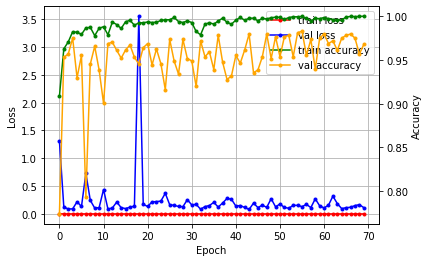

  0%|          | 0/37 [00:00<?, ?it/s]

epoch:71/100 [train]loss0.000000 acc:1.0000, [val]loss:0.111468, acc:0.9677


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:72/100 [train]loss0.000000 acc:1.0000, [val]loss:0.116484, acc:0.9797


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:73/100 [train]loss0.000000 acc:1.0000, [val]loss:0.113418, acc:0.9812


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:74/100 [train]loss0.000000 acc:1.0000, [val]loss:0.113530, acc:0.9646


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:75/100 [train]loss0.000000 acc:1.0000, [val]loss:0.110392, acc:0.9812


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:76/100 [train]loss0.000000 acc:1.0000, [val]loss:0.111965, acc:0.9828


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:77/100 [train]loss0.000000 acc:1.0000, [val]loss:0.112760, acc:0.9812


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:78/100 [train]loss0.000000 acc:1.0000, [val]loss:0.113320, acc:0.9812


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:79/100 [train]loss0.000000 acc:1.0000, [val]loss:0.116070, acc:0.9781


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:80/100 [train]loss0.000000 acc:1.0000, [val]loss:0.115788, acc:0.9812


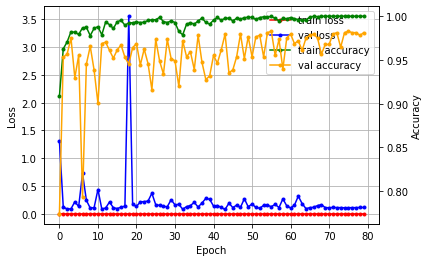

  0%|          | 0/37 [00:00<?, ?it/s]

epoch:81/100 [train]loss0.000000 acc:1.0000, [val]loss:0.116087, acc:0.9828


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:82/100 [train]loss0.000000 acc:1.0000, [val]loss:0.117511, acc:0.9630


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:83/100 [train]loss0.000000 acc:1.0000, [val]loss:0.117260, acc:0.9797


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:84/100 [train]loss0.000000 acc:1.0000, [val]loss:0.122605, acc:0.9781


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:85/100 [train]loss0.000000 acc:1.0000, [val]loss:0.119087, acc:0.9781


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:86/100 [train]loss0.000000 acc:1.0000, [val]loss:0.121114, acc:0.9630


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:87/100 [train]loss0.000000 acc:1.0000, [val]loss:0.120623, acc:0.9677


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:88/100 [train]loss0.000000 acc:1.0000, [val]loss:0.121238, acc:0.9812


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:89/100 [train]loss0.000000 acc:1.0000, [val]loss:0.121053, acc:0.9630


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:90/100 [train]loss0.000000 acc:1.0000, [val]loss:0.124696, acc:0.9781


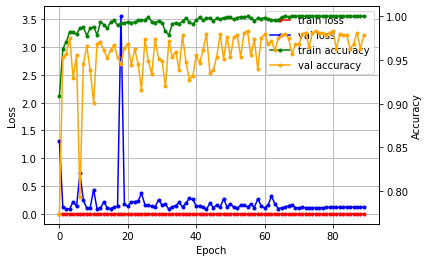

  0%|          | 0/37 [00:00<?, ?it/s]

epoch:91/100 [train]loss0.000000 acc:1.0000, [val]loss:0.121433, acc:0.9510


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:92/100 [train]loss0.000000 acc:1.0000, [val]loss:0.121615, acc:0.9812


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:93/100 [train]loss0.000000 acc:1.0000, [val]loss:0.121833, acc:0.9812


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:94/100 [train]loss0.000000 acc:1.0000, [val]loss:0.122505, acc:0.9781


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:95/100 [train]loss0.000000 acc:1.0000, [val]loss:0.122960, acc:0.9630


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:96/100 [train]loss0.000000 acc:1.0000, [val]loss:0.126233, acc:0.9766


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:97/100 [train]loss0.000000 acc:1.0000, [val]loss:0.125386, acc:0.9766


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:98/100 [train]loss0.000000 acc:1.0000, [val]loss:0.125487, acc:0.9812


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:99/100 [train]loss0.000000 acc:1.0000, [val]loss:0.125663, acc:0.9781


  0%|          | 0/37 [00:00<?, ?it/s]

epoch:100/100 [train]loss0.000000 acc:1.0000, [val]loss:0.126576, acc:0.9646


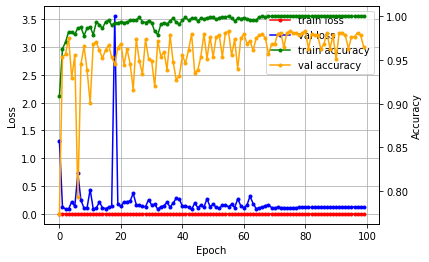

In [88]:
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

for epoch in range(EPOCH):
    model.train()

    tr_loss = 0
    correct = 0
    total = 0

    train_time_start = time.time()

    step = 0
    batch_accuracy = 0
    for inputs, targets in tqdm(dataloader_train):
        optimizer.zero_grad()

        n_batch = len(inputs)

        inputs = inputs.to(device)
        targets = targets.to(torch.float32)
        targets = targets.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, targets)

        loss = loss / n_batch
        loss.backward()

        loss = loss.item()
        tr_loss += loss / train_n

        optimizer.step()
        
        b_outputs = outputs.squeeze().cpu().detach().numpy().copy()
        b_targets = targets.squeeze().cpu().detach().numpy().copy()
        b_outputs = np.where(b_outputs>0.5, 1.0, 0.0)
        batch_accuracy += accuracy_score(b_targets, b_outputs)
        step += 1

    train_losses.append(tr_loss)
    train_accuracy = batch_accuracy/step
    train_accuracies.append(train_accuracy)

    train_time_end = time.time()

    model.eval()

    val_loss = 0
    val_correct = 0
    val_total= 0

    val_time_start = time.time()

    step = 0
    batch_accuracy = 0
    with torch.no_grad():
        for val_inputs, val_targets in dataloader_val:
            
            val_inputs = val_inputs.to(device)
            val_targets = val_targets.to(torch.float32)
            val_targets = val_targets.to(device)
            
            val_outputs = model(val_inputs)

            loss = criterion(val_outputs, val_targets)

            val_loss += loss.item() / val_n

            b_outputs = val_outputs.squeeze().cpu().numpy().copy()
            b_targets = val_targets.squeeze().cpu().numpy().copy()
            b_outputs = np.where(b_outputs>0.5, 1.0, 0.0)
            batch_accuracy += accuracy_score(b_targets, b_outputs)
            step += 1

    val_accuracy = batch_accuracy / step
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)

    val_time_end = time.time()
    train_time = train_time_end - train_time_start
    val_time = val_time_end - val_time_start
    total_time = train_time + val_time

    print(f"epoch:{epoch+1}/{EPOCH} [train]loss{tr_loss:.6f} acc:{train_accuracy:.4f}, [val]loss:{val_loss:.6f}, acc:{val_accuracy:.4f}")

    if (epoch+1) % 10 == 0:
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.grid()
        ax1.plot(train_losses, marker=".", markersize=6, color="red", label="train loss")
        ax1.plot(val_losses, marker=".", markersize=6, color="blue", label="val loss")
        ax2.plot(train_accuracies, marker=".", markersize=6, color="green", label="train accuracy")
        ax2.plot(val_accuracies, marker=".", markersize=6, color="orange", label="val accuracy")
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2, loc="upper right")
        ax1.set(xlabel="Epoch", ylabel="Loss")
        ax2.set(ylabel="Accuracy")
        plt.show()


# Test

In [89]:
x_test = reshape(x_test)

transforms_test = transforms.Compose([
    transforms.ToTensor(),
])
dataset_test = MedMNISTDataset(xs=x_test, ys=y_test, transforms=transforms_test)

test_n = len(dataset_test)

dataloader_test = DataLoader(dataset_test, batch_size=2*BATCH_SIZE)

model.eval()

step = 0
batch_accuracy = 0
with torch.no_grad():
    for inputs, targets in dataloader_test:
        n_batch = len(inputs)

        inputs = inputs.to(device)
        targets = targets.to(torch.float32)
        targets = targets.to(device)
        
        outputs = model(inputs)
        
        b_outputs = outputs.squeeze().cpu().numpy().copy()
        b_targets = targets.squeeze().cpu().numpy().copy()
        b_outputs = np.where(b_outputs>0.5, 1.0, 0.0)
        batch_accuracy += accuracy_score(b_targets, b_outputs)
        step += 1

test_accuracy = batch_accuracy / step

print(f'{100*test_accuracy:.2f}%')


86.64%
